# Predicción de demanda de bicicletas

Somos data scientists para Valenbisi (o tu empresa de alquiler de bicicletas favorita). Tenemos datos de demanda de cada hora durante 2 años. La empresa quiere mejorar la gestión de las bicicletas en la ciudad. Siempre tenemos algunas bicicletas en la calle y algunas más en el almacén. No queremos demasiadas bicicletas en la ciudad porque se estropean - pero tampoco queremos demasiadas pocas porque así la gente no las puede utilizar.

Si tuviéramos una predicción de la demanda en cada hora, pensamos que podríamos mejorar la gestión (si sé que me van a alquilar 100 bicicletas, pues pongo 100). Tu tarea es desarrollar un modelo para predecir dicha demanda en cada hora.

Todos los puntos deben responderse tanto con código (en la gran mayoría de los casos) y texto. Debes utilizar tu propio sentido común en conjunto con los datos para argumentar tus decisiones. Las preguntas se puntúan en base de la metodología utilizada y la comunicación de dicha metodología. No se restan puntos por una decisión “equivocada” con un argumento válido. Las preguntas bonus no restan - solo suman (es posible conseguir 100% sin contestarlas).

In [298]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import OrdinalEncoder

SPLIT_THRESHOLD = 0.3
RANDOM_SEED = 2055

## Carga de datos
1. Carga los datos y compruebe que se hayan cargado bien

In [299]:
df = pd.read_csv('./exam_data.csv')
df

,timestamp,season,holiday,weather,temperature,feels_like_temperature,humidity,wind_speed,casual,registered,total
0,2011-01-01 00:00:00,Winter,0,Clear,9.84,14.395,81.0,0.0000,3,13,16
1,2011-01-01 01:00:00,Winter,0,Clear,9.02,13.635,80.0,0.0000,8,32,40
2,2011-01-01 02:00:00,Winter,0,Clear,9.02,13.635,80.0,0.0000,5,27,32
3,2011-01-01 03:00:00,Winter,0,Clear,9.84,14.395,75.0,0.0000,3,10,13
4,2011-01-01 04:00:00,Winter,0,Clear,9.84,14.395,75.0,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...
17374,2012-12-31 19:00:00,Winter,0,Mist,10.66,12.880,60.0,11.0014,11,108,119
17375,2012-12-31 20:00:00,Winter,0,Mist,10.66,12.880,60.0,11.0014,8,81,89
17376,2012-12-31 21:00:00,Winter,0,Clear,10.66,12.880,60.0,11.0014,7,83,90
17377,2012-12-31 22:00:00,Winter,0,Clear,10.66,13.635,56.0,8.9981,13,48,61


In [300]:
df.describe()

,holiday,temperature,feels_like_temperature,humidity,wind_speed,casual,registered,total
count,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,0.028770,20.376474,23.788755,62.722884,12.736540,35.676218,153.786869,189.463088
std,0.167165,7.894801,8.592511,19.292983,8.196795,49.305030,151.357286,181.387599
min,0.000000,0.820000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,13.940000,16.665000,48.000000,7.001500,4.000000,34.000000,40.000000
50%,0.000000,20.500000,24.240000,63.000000,12.998000,17.000000,115.000000,142.000000
75%,0.000000,27.060000,31.060000,78.000000,16.997900,48.000000,220.000000,281.000000
max,1.000000,41.000000,50.000000,100.000000,56.996900,367.000000,886.000000,977.000000


In [301]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   timestamp               17379 non-null  object 
 1   season                  17379 non-null  object 
 2   holiday                 17379 non-null  int64  
 3   weather                 17379 non-null  object 
 4   temperature             17379 non-null  float64
 5   feels_like_temperature  17379 non-null  float64
 6   humidity                17379 non-null  float64
 7   wind_speed              17379 non-null  float64
 8   casual                  17379 non-null  int64  
 9   registered              17379 non-null  int64  
 10  total                   17379 non-null  int64  
dtypes: float64(4), int64(4), object(3)
memory usage: 1.5+ MB


In [302]:
df.isnull().sum()

timestamp                 0
season                    0
holiday                   0
weather                   0
temperature               0
feels_like_temperature    0
humidity                  0
wind_speed                0
casual                    0
registered                0
total                     0
dtype: int64

In [303]:
# Transform the timestamp into a pandas datetime object. Will come handy later

df['timestamp'] = pd.to_datetime(df['timestamp'])
df['timestamp'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 17379 entries, 0 to 17378
Series name: timestamp
Non-Null Count  Dtype         
--------------  -----         
17379 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 135.9 KB


- The dataset has been loaded into the program correctly, every feature has the values expect for it and there are no missing or null values.

2. ¿Qué representa cada fila de nuestros datos?

- Each row of the dataset represent a timestamp (in intervals of one hour) of the years 2011 and 2012 with the following information:
    - Weather data: how was the weather at that point of time (temperature, season., humidity, etc...)
    - Usage: amount of people using the bicycles (both casual and registered people)

## Análisis de datos

1. ¿Cuál es la temperatura y humedad media de cada estación?

In [304]:
seasonal_avg_temp_humid = df.groupby('season')[['temperature', 'humidity']].mean().reset_index()

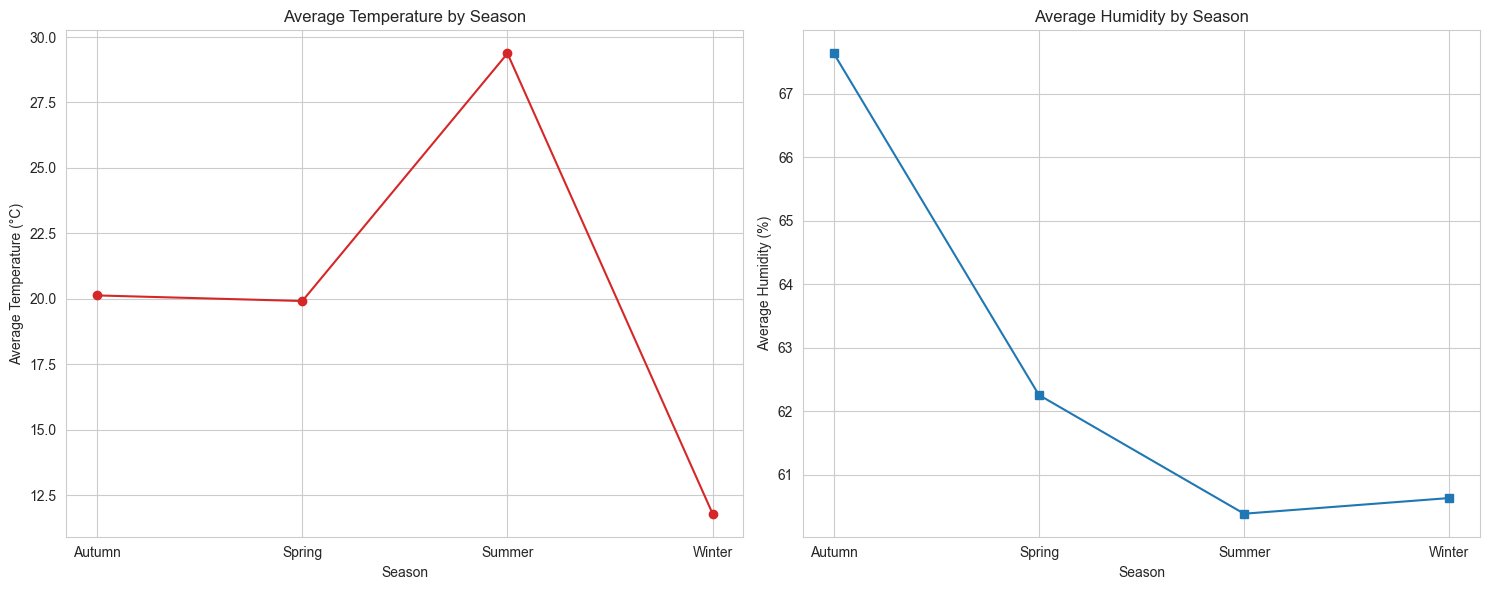

In [305]:
# Creating a figure with two subplots (one for temperature and one for humidity) arranged horizontally
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Temperature plot on the first subplot
ax1.plot(seasonal_avg_temp_humid['season'], seasonal_avg_temp_humid['temperature'], color='tab:red', marker='o',
         linestyle='-')
ax1.set_title('Average Temperature by Season')
ax1.set_xlabel('Season')
ax1.set_ylabel('Average Temperature (°C)')
ax1.grid(True)

# Humidity plot on the second subplot
ax2.plot(seasonal_avg_temp_humid['season'], seasonal_avg_temp_humid['humidity'], color='tab:blue', marker='s',
         linestyle='-')
ax2.set_title('Average Humidity by Season')
ax2.set_xlabel('Season')
ax2.set_ylabel('Average Humidity (%)')
ax2.grid(True)

# Adjust layout for better fit
plt.tight_layout()

Looking at the graphs, we can make the following conclusions:
- As expected the average temperature is higher during summer and lower during winter, this could lead to higher bicycle usage during warmer temperatures and less usage when it's colder.
- Humidity is higher in autumn, meaning it rains more often and cause less bicycle usage

2. ¿Se registran más usuarios casuales o registrados? ¿Esto cambia en el tiempo?

In [306]:
df['year_month'] = df['timestamp'].dt.to_period('M')
monthly_data = df.groupby('year_month').agg({'casual': 'sum', 'registered': 'sum'}).reset_index()
monthly_data['year_month'] = monthly_data['year_month'].astype(str)
monthly_data

,year_month,casual,registered
0,2011-01,3073,35116
1,2011-02,6242,41973
2,2011-03,12826,51219
3,2011-04,22346,72524
4,2011-05,31050,104771
5,2011-06,30612,112900
6,2011-07,36452,104889
7,2011-08,28842,107849
8,2011-09,26545,100873
9,2011-10,25222,98289


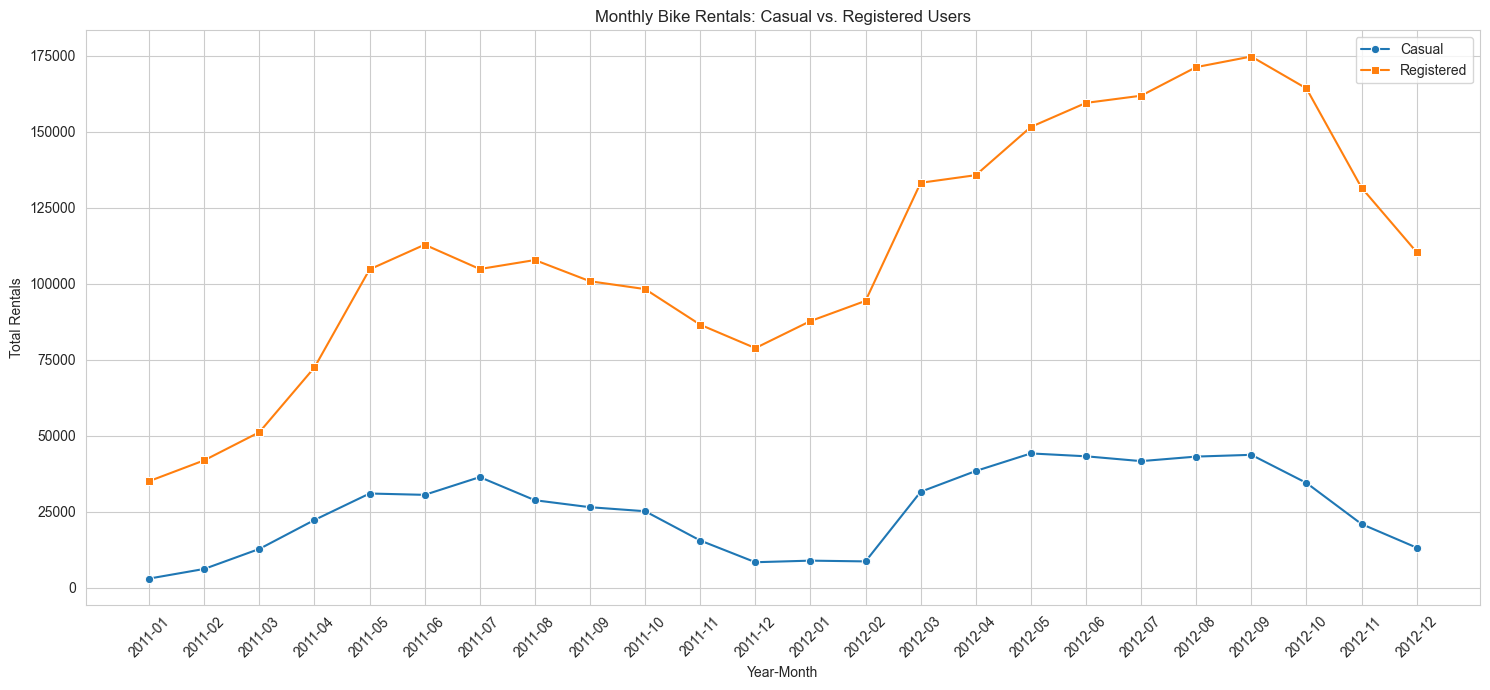

In [307]:
plt.figure(figsize=(15, 7))
sns.lineplot(data=monthly_data, x='year_month', y='casual', marker='o', label='Casual')
sns.lineplot(data=monthly_data, x='year_month', y='registered', marker='s', label='Registered')

plt.xticks(rotation=45)
plt.title('Monthly Bike Rentals: Casual vs. Registered Users')
plt.xlabel('Year-Month')
plt.ylabel('Total Rentals')
plt.legend()
plt.tight_layout()

plt.show()


Looking at the graph, we can take the following conclusions:
- Registered users use the service more than double as casual users.
- There is an increased number of usage during the warmer seasons than then decays when cold comes again. 
- There has been a light increase of casual users, but a pretty high increase on registered users. This could mean casual users become registered users during the time

# Preparación de datos y relevancia de datos

1. Compruebe la calidad de las variables que te parecen más interesantes - aplica cualquier arreglo que ves necesario
3. Analiza la relevancia de las variables elegidas y comenta lo que encuentras

At first glance the most relevant features for the problems are
- Timestamp (hour of the day): the whole timestamp probably is too much information. However, the hour of the day is rather relevant. For example: it doesn't matter that it is day 1 or 16 of the month, but a lot more bicycles will be used at 8:00am than 1:00 because people use it to go to work, class, etc...
- Feels like temperature: this variable is pretty similar to variable temperature (they have high correlation). So given that only one can be used, this variable feels more important.
- Weather: for a bicycle service it is rather important how the weather is. If the weather conditions are not favorable, people would choose other vehicles. The column has different weather status, but probably it would be a better idea to just choose clear or not.
- Season: not only influences temperature, but also indicates when holidays and vacations are. It is a categorical data and therefore we must encode it.

Target variable:
- The problem presents us 3 possible targets to predict: the amount casual users, the amount of registered users and both. This could potentially lead to make different models for each one of the variables. For the problem given, which is prediction the amount of bicycles needed in total, the most appropriate target to predict is 'total'. Therefore, we will discard the other 2 variables (casual and registered) even thought for other purposes they could come handy.

In [308]:
# Get the hour of the day for
df['timestamp_hour'] = df['timestamp'].dt.hour

In [309]:
# Encode weather to: Clear -> 1 | The rest -> 0

def encode_weather(weather):
    if weather == 'Clear':
        return 1
    return 0


df['weather'] = df['weather'].apply(encode_weather)
df

,timestamp,season,holiday,weather,temperature,feels_like_temperature,humidity,wind_speed,casual,registered,total,year_month,timestamp_hour
0,2011-01-01 00:00:00,Winter,0,1,9.84,14.395,81.0,0.0000,3,13,16,2011-01,0
1,2011-01-01 01:00:00,Winter,0,1,9.02,13.635,80.0,0.0000,8,32,40,2011-01,1
2,2011-01-01 02:00:00,Winter,0,1,9.02,13.635,80.0,0.0000,5,27,32,2011-01,2
3,2011-01-01 03:00:00,Winter,0,1,9.84,14.395,75.0,0.0000,3,10,13,2011-01,3
4,2011-01-01 04:00:00,Winter,0,1,9.84,14.395,75.0,0.0000,0,1,1,2011-01,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,2012-12-31 19:00:00,Winter,0,0,10.66,12.880,60.0,11.0014,11,108,119,2012-12,19
17375,2012-12-31 20:00:00,Winter,0,0,10.66,12.880,60.0,11.0014,8,81,89,2012-12,20
17376,2012-12-31 21:00:00,Winter,0,1,10.66,12.880,60.0,11.0014,7,83,90,2012-12,21
17377,2012-12-31 22:00:00,Winter,0,1,10.66,13.635,56.0,8.9981,13,48,61,2012-12,22


In [310]:
season_sorted = ["Winter", "Spring", "Summer", "Autumn"]
seasons = df[['season']]

encoder = OrdinalEncoder(categories=[season_sorted])
encoded_season = encoder.fit_transform(seasons)

df['season'] = encoded_season
df['season']

0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
17374    0.0
17375    0.0
17376    0.0
17377    0.0
17378    0.0
Name: season, Length: 17379, dtype: float64

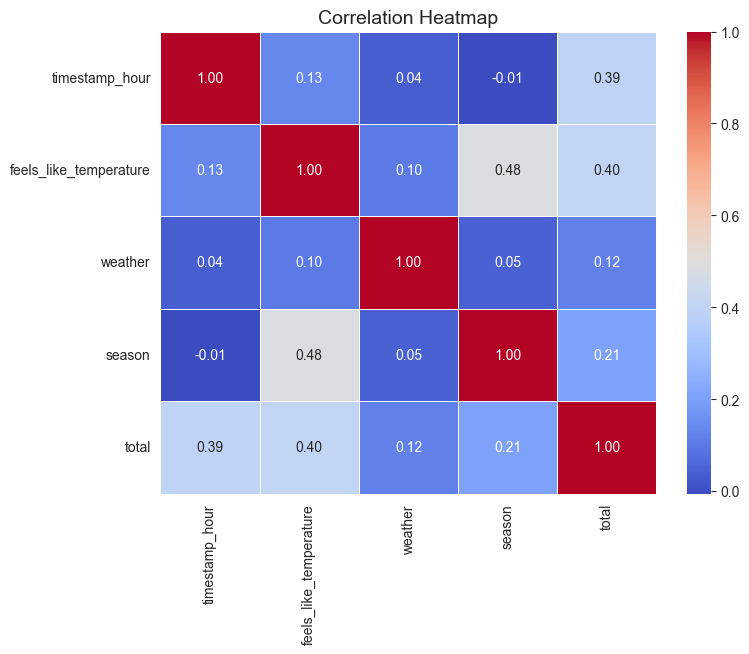

In [311]:
features_to_analyze = ['timestamp_hour', 'feels_like_temperature', 'weather', 'season', 'total']
correlation_matrix = df[features_to_analyze].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap', fontsize=14)
plt.show()

-  After analyzing the relevance of the variables and decide which 

In [312]:
features_chosen = [
    'timestamp_hour',
    'feels_like_temperature',
    'weather',
    'season',
]
target = 'total'

In [313]:
X = df[features_chosen]
y = df[target]

2. Divide tus datos en train y test

In [314]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=SPLIT_THRESHOLD, random_state=RANDOM_SEED)

## Creación del modelo

1. Crea un modelo de regresión lineal

In [315]:
model = LinearRegression()
model = model.fit(X_train, y_train)

2. Genera predicciones sobre los datos de test

In [316]:
y_predict = model.predict(X_test)

## Evaluación del modelo

1. Elige las métricas más relevantes para la evaluación de tus predicciones y saca los valores

The metrics chosen to evaluate the model are: 
- Mean absolute error
- Median absolute error
- Root mean squared error

They were chosen because they are the most common metrics for linear regression problems overall.

In [317]:
# Printing to console metrics about prediction results with test dataset

print("Test dataset metrics")
print()

mean_test_bicycles = y_test.mean()
print(f"Mean is {mean_test_bicycles:,.2f} bicycles")

baseline = np.empty(len(y_test))
baseline.fill(mean_test_bicycles)
baseline_mean_absolute_error = metrics.mean_absolute_error(y_test, baseline)
baseline_median_absolute_error = metrics.median_absolute_error(y_test, baseline)
baseline_root_mean_squared_error = metrics.mean_squared_error(y_test, baseline, squared=False)

print()
print("Model baseline:")
print(
    f"Mean absolute error: {baseline_mean_absolute_error:,.2f} bicycles ({(baseline_mean_absolute_error / mean_test_bicycles * 100):,.2f}% off)")
print(
    f"Median absolute error: {baseline_median_absolute_error:,.2f} bicycles ({(baseline_median_absolute_error / mean_test_bicycles * 100):,.2f}% off)")
print(
    f"Root Mean squared error: {baseline_root_mean_squared_error:,.2f} bicycles ({(baseline_root_mean_squared_error / mean_test_bicycles * 100):,.2f}% off)")

metric_mean_absolute_error = metrics.mean_absolute_error(y_test, y_predict)
metric_median_absolute_error = metrics.median_absolute_error(y_test, y_predict)
metric_root_mean_squared_error = metrics.mean_squared_error(y_test, y_predict, squared=False)

print()
print("Model metrics:")
print(
    f"Mean absolute error: {metric_mean_absolute_error:,.2f} bicycles ({(metric_mean_absolute_error / mean_test_bicycles * 100):,.2f}% off)")
print(
    f"Median absolute error: {metric_median_absolute_error:,.2f} bicycles ({(metric_median_absolute_error / mean_test_bicycles * 100):,.2f}% off)")
print(
    f"Root mean squared error: {metric_root_mean_squared_error:,.2f} bicycles ({(metric_root_mean_squared_error / mean_test_bicycles * 100):,.2f}% off)")

Test dataset metrics

Mean is 189.84 bicycles

Model baseline:
Mean absolute error: 142.29 bicycles (74.95% off)
Median absolute error: 131.84 bicycles (69.45% off)
Root Mean squared error: 181.38 bicycles (95.54% off)

Model metrics:
Mean absolute error: 112.98 bicycles (59.52% off)
Median absolute error: 89.28 bicycles (47.03% off)
Root mean squared error: 153.56 bicycles (80.89% off)


2. Comenta sobre los resultados - ¿nuestro modelo sería útil para conseguir nuestro objetivo? ¿Cómo dirías al departamento de operaciones que se debería de utilizar?

- The model doesn't perform very well overall, metrics shows prediction are not quite accurate. However, the model can still yield some positive results if used the right way. 
- It is important to note the model does outperform the baseline and has a pretty low cost to make (considering the dataset was already there). This means that, even if predictions aren't perfect, it can still give some interesting leads on where the company could make improvements, with a relatively low cost. 
- The model won't be able to make perfect usage predictions to achieve our main objective given by the problem. However, this model can still be used by the OPS department to detect posible outliers that the model detected and don't make more accurate guesses on where to place more or less bicycles.

# Preguntas bonus

1. Si tuvieras mucho más tiempo para hacer un modelo mejor - por donde tirarías?

If I had more time to make a better model I would try out the following:
- Better variable analysis: the variables chosen for this model were chosen by looking at simple metrics and some intuition. However, this could mean some important data has been let off. A better understanding of the business logic could help extracting better features and making a better model.
- Splitting data by time: In this model the data is split by a chosen percent, but I feel like it would be more appropriate to split train and test by date, and keep the most recent data as the tests dataset. This would benefit the model because the test by making the tests data closer to the actual date (ignoring the dataset is from 2012) and yield more accurate prediction. For example: if the company has had a considerable growth in the past month/year the usage of the service would be outdated and not that relevant for the model.
- Also, I would make a third dataset 'validation' so I could use it to check the prediction made by the model against data that it has not seen.
- Another interesting approach would be making prediction for casual and registered users separately. These 2 groups of users can behave differently during the year, so might be better make 2 models and then combine them.
- Use the previous timestamp usage: making a model that consider how the usage was the last time just before making the prediction could be an important factor for the model. For example: at 8:00 the usage was 100 bicycles, so at 9:00 it is very likely to be a similar number. There might be spikes during rush hours, but still I think it could be a really useful variable.

2. ¿Echas de menos alguna variable o dato que crees que podría mejorar el modelo?

- The variable I miss the most in this problem is a location variable. Valencia is a rather large city, so having some information about neighborhoods or similar could be quite interesting for the model.

3. ¿Ves alguna limitación con nuestra metodología (usar los datos de demanda para gestionar recursos de bicicletas)?

- I think the historic usage data of the service is ok overall to make predictions, the bigger limitation I see for the dataset is that it relies on a bit too much on old data that might just be outdated. If the service is in expansion, it really doesn't matter that much which were the metrics when the volume of work is so much higher now.